In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'

import fractionalcontribution as fc

In [2]:
plasmadata = "/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/data/metabolomics/Plasma_summary.xlsx"
tissuedata = "/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/data/metabolomics/Tissue_summary.xlsx"

plasmanormalizedlabeling = pd.read_excel(plasmadata, sheet_name=2, header=0)

tissuenormalizedlabeling = pd.read_excel(tissuedata, sheet_name=2, header=0)

# Normalized Labeling Data Analyses

Because the H and the C were able to be detected separately on the HRMS, it is possible to treat these datasets as "separate infusions"

Sum the different 2H all of the C13 measures

In [3]:
#Separate normalized dataframes into 2H and 13C dataframes separately
#Sum over each of the compounds' isotopologues for H or C, then drop the column with the other isotope's identifier

plasma2H = plasmanormalizedlabeling.groupby(['Compound','2H#']).sum().drop(columns=['13C#']).reset_index(level=[0,1])
tissue2H = tissuenormalizedlabeling.groupby(['Compound','2H#']).sum().drop(columns=['13C#']).reset_index(level=[0,1])

plasma13C = plasmanormalizedlabeling.groupby(['Compound','13C#']).sum().drop(columns=['2H#']).reset_index(level=[0,1])
tissue13C = tissuenormalizedlabeling.groupby(['Compound','13C#']).sum().drop(columns=['2H#']).reset_index(level=[0,1])

# Plasma Glutamine APE (Only 13C labeled Substrate)

In [4]:
#Get just the columns with numbers in it to cycle through the MDVs with the APE function of the fractional contribution package
plasma13C = plasma13C[plasma13C['Compound'] == 'glutamine'].filter(regex='120')

In [5]:
plasmaglutamine_APE = []

for column in plasma13C:
    MDV = plasma13C[column]
    x = fc.FractionalAPE(np.array(MDV))
    plasmaglutamine_APE.append(x)

#This list contains all of the plasma glutamine APEs in order for each mouse
plasmaglutamine_APE

[0.10346535695772785,
 0.07938803593591716,
 0.1294206661597859,
 0.07726959114141162,
 0.06733278000347986,
 0.07230068379896054,
 0.10979942568510855,
 0.06888971763403963,
 0.07486253314563235,
 0.06796373840095314,
 0.09491749002750353,
 0.12044116634955242,
 0.11075127173367383,
 0.09901828859596734,
 0.09203006205264677]

Isolate list of metabolites of interest for fractional nutrient contributions

In [6]:
metabolites = ['a-ketoglutarate', 'succinate', 'malate', 'proline', 'aspartate', 'AMP']

In [7]:
tissue13C = tissue13C[tissue13C['Compound'].isin(metabolites)]

# Tissue-Specific APEs

Easiest to first break each tissue into its own dataframe, then perform Sepsis vs. Sham analysis for APE for all metabolites

In [8]:
#make new dataframes for each tissue by combining dataframe with compound name and C label and columns with unique tissue identifier
#temporary dataframes will be all caps, permanent will be lowercase with tracer ID
tissue13C_labels = tissue13C.iloc[: , :2]
HEART = tissue13C.filter(regex='heart')
KIDNEY = tissue13C.filter(regex='kidney')
LIVER = tissue13C.filter(regex='liver')
QUAD = tissue13C.filter(regex='quad')
TUMOR = tissue13C.filter(regex='tumor')


heart_13C = pd.concat([tissue13C_labels, HEART], axis=1)
kidney_13C = pd.concat([tissue13C_labels, KIDNEY], axis=1)
liver_13C = pd.concat([tissue13C_labels, LIVER], axis=1)
quad_13C = pd.concat([tissue13C_labels, QUAD], axis=1)
tumor_13C = pd.concat([tissue13C_labels, TUMOR], axis=1)

In [18]:
quad_13C.to_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/data/metabolomics/quad_13C.csv')

In [9]:
#Create a list of all unique measured metabolites
#The metabolites are the same for all tissues so can do this once
tissue13C_metabolites = tissue13C['Compound'].unique().tolist()

In [10]:
#create a list of each sample for loops later
#Will need to do this for each tissue (would be nice to turn into a loop at some point!)
heart_13C_samples = heart_13C.columns[2:].tolist()
kidney_13C_samples = kidney_13C.columns[2:].tolist()
liver_13C_samples = liver_13C.columns[2:].tolist()
quad_13C_samples = quad_13C.columns[2:].tolist()
tumor_13C_samples = tumor_13C.columns[2:].tolist()

In [11]:
#Create a new dataframe for each individual metabolite and store in a dictionary

dict_of_heart13C_metabolites = dict(tuple(heart_13C.groupby("Compound")))
dict_of_kidney13C_metabolites = dict(tuple(kidney_13C.groupby("Compound")))
dict_of_liver13C_metabolites = dict(tuple(liver_13C.groupby("Compound")))
dict_of_quad13C_metabolites = dict(tuple(quad_13C.groupby("Compound")))
dict_of_tumor13C_metabolites = dict(tuple(tumor_13C.groupby("Compound")))

Heart

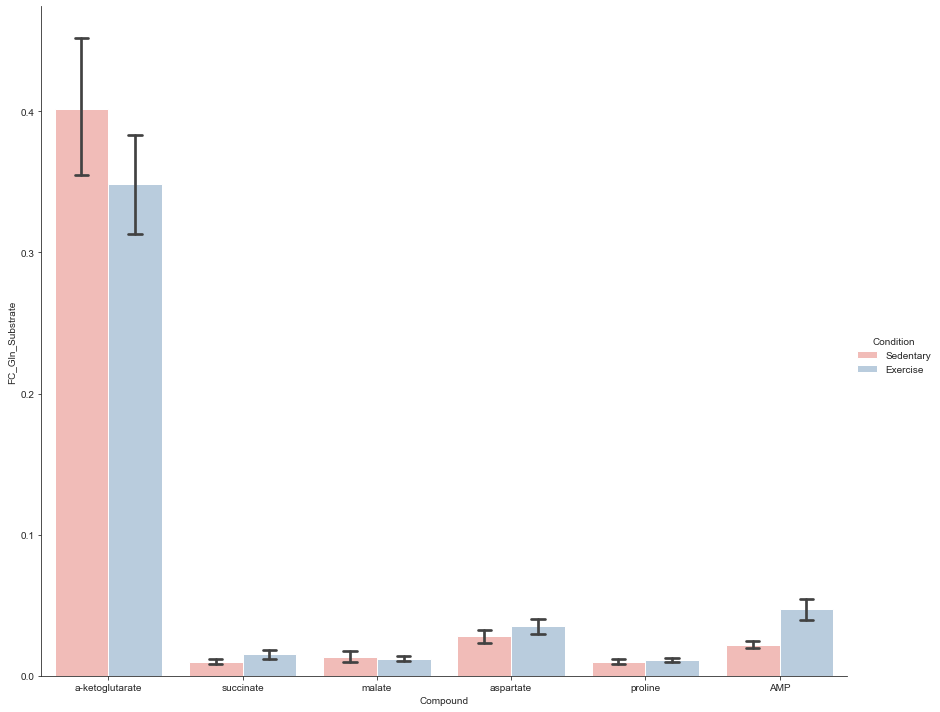

In [12]:
#This nested for loop prints out every APE for every sample and every metabolite

#arange starts at 2 because the first two columns are strings, and I then have to add that same number (2) in order to complete the list
Sample = []
Compound = []
APE = []

for metabolite in tissue13C_metabolites:
    for sample in np.arange(2,(len(heart_13C_samples)+2)):

        #I have to do sample minus 1, because I want to start from the third column in my dataframes (which is the first mouse)

        x, y, z = (sample-1, metabolite, fc.FractionalAPE(dict_of_heart13C_metabolites[metabolite].iloc[:, sample]))
        Sample.append(x)
        Compound.append(y)
        APE.append(z)

heart_APEs = pd.DataFrame({'Sample': Sample, 'Compound': Compound, 'APE': APE})

#Add a column to the dataframe that puts plasma glutamine APE
heart_APEs['Plasma_Glutamine_APE'] = plasmaglutamine_APE * len(heart_APEs['Compound'].unique())
#add a column that specifies the mouse's Condition
heart_APEs['Condition'] = ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary'] * len(heart_APEs['Compound'].unique())
#add a column that plots the FC_Glu-->Compound as APE / Plasma_Glutamine_APE
heart_APEs['FC_Gln_Substrate'] = heart_APEs['APE'] / heart_APEs['Plasma_Glutamine_APE']
#add a column that specifies the tissue for the combined dataframe later
heart_APEs['Tissue'] = 'heart'

sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=heart_APEs, saturation=0.75, palette = 'Pastel1', order=['a-ketoglutarate', 'succinate', 'malate', 'aspartate','proline', 'AMP'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=1.2)

Kidney

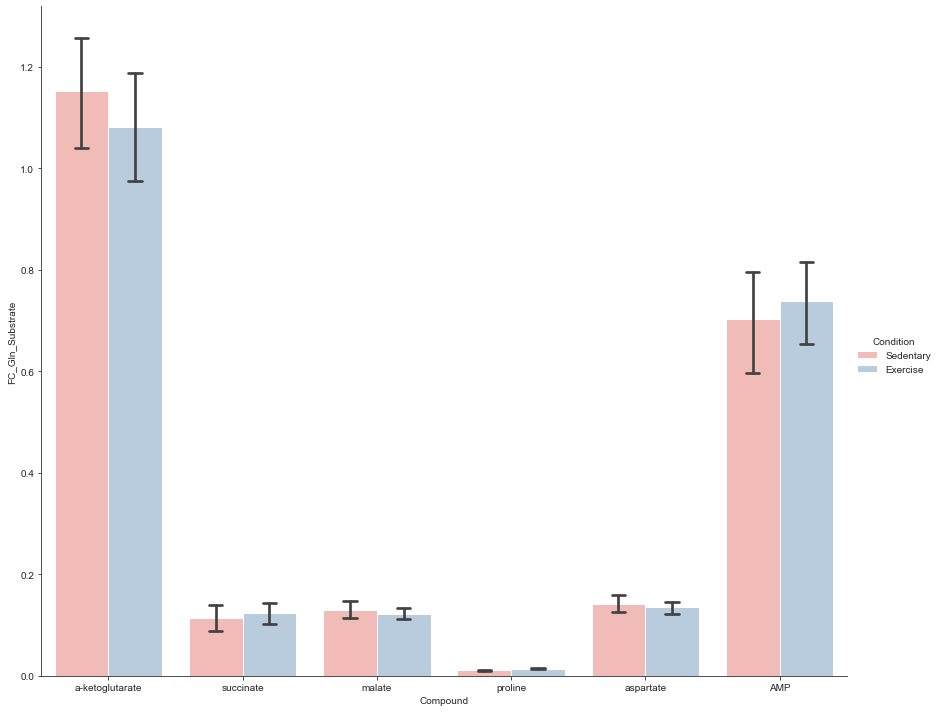

In [13]:
#This nested for loop prints out every APE for every sample and every metabolite

#arange starts at 2 because the first two columns are strings, and I then have to add that same number (2) in order to complete the list
Sample1 = []
Compound1 = []
APE1 = []

for metabolite in tissue13C_metabolites:
    for sample in np.arange(2,(len(kidney_13C_samples)+2)):

        #I have to do sample minus 1, because I want to start from the third column in my dataframes (which is the first mouse)

        x, y, z = (sample-1, metabolite, fc.FractionalAPE(dict_of_kidney13C_metabolites[metabolite].iloc[:, sample]))
        Sample1.append(x)
        Compound1.append(y)
        APE1.append(z)

kidney_APEs = pd.DataFrame({'Sample': Sample1, 'Compound': Compound1, 'APE': APE1})

#Add a column to the dataframe that puts plasma glutamine APE

#Missing Kidney #14 so I will remove the plasma glutamine from sample 14
kidney_APEs['Plasma_Glutamine_APE'] = [0.10346535695772785, 0.07938803593591716, 0.1294206661597859, 0.07726959114141162, 0.06733278000347986, 0.07230068379896054, 0.10979942568510855, 0.06888971763403963, 0.07486253314563235, 0.06796373840095314, 0.09491749002750353, 0.12044116634955242, 0.09901828859596734, 0.09203006205264677] * len(kidney_APEs['Compound'].unique())
#add a column that specifies the mouse's Condition

#Missing Kidney #14
kidney_APEs['Condition'] = ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary'] * len(kidney_APEs['Compound'].unique())
#add a column that plots the FC_Glu-->Compound as APE / Plasma_Glutamine_APE
kidney_APEs['FC_Gln_Substrate'] = kidney_APEs['APE'] / kidney_APEs['Plasma_Glutamine_APE']
#add a column that specifies the tissue for the combined dataframe later
kidney_APEs['Tissue'] = 'kidney'

sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=kidney_APEs, saturation=0.75, palette = 'Pastel1', order=['a-ketoglutarate', 'succinate', 'malate', 'proline', 'aspartate', 'AMP'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=1.2)

Liver

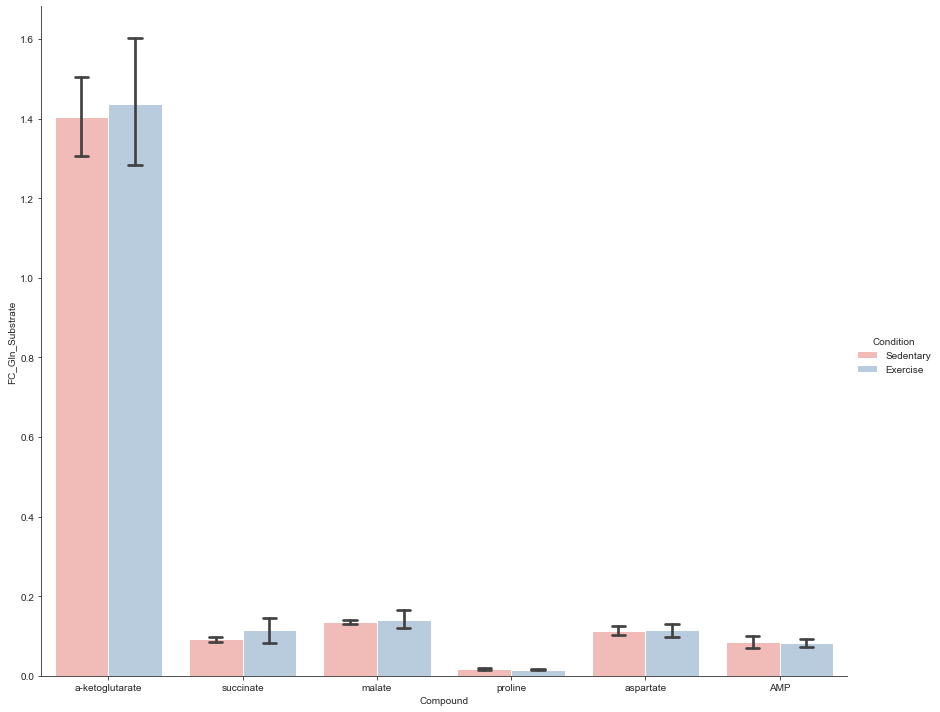

In [14]:
#This nested for loop prints out every APE for every sample and every metabolite

#arange starts at 2 because the first two columns are strings, and I then have to add that same number (2) in order to complete the list
Sample = []
Compound = []
APE = []

for metabolite in tissue13C_metabolites:
    for sample in np.arange(2,(len(liver_13C_samples)+2)):

        #I have to do sample minus 1, because I want to start from the third column in my dataframes (which is the first mouse)

        x, y, z = (sample-1, metabolite, fc.FractionalAPE(dict_of_liver13C_metabolites[metabolite].iloc[:, sample]))
        Sample.append(x)
        Compound.append(y)
        APE.append(z)

liver_APEs = pd.DataFrame({'Sample': Sample, 'Compound': Compound, 'APE': APE})

#Add a column to the dataframe that puts plasma glutamine APE
liver_APEs['Plasma_Glutamine_APE'] = plasmaglutamine_APE * len(liver_APEs['Compound'].unique())
#add a column that specifies the mouse's Condition
liver_APEs['Condition'] = ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary'] * len(liver_APEs['Compound'].unique())
#add a column that plots the FC_Glu-->Compound as APE / Plasma_Glutamine_APE
liver_APEs['FC_Gln_Substrate'] = liver_APEs['APE'] / liver_APEs['Plasma_Glutamine_APE']
#add a column that specifies the tissue for the combined dataframe later
liver_APEs['Tissue'] = 'liver'

sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=liver_APEs, saturation=0.75, palette = 'Pastel1', order=['a-ketoglutarate', 'succinate', 'malate', 'proline', 'aspartate', 'AMP'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=1.2)

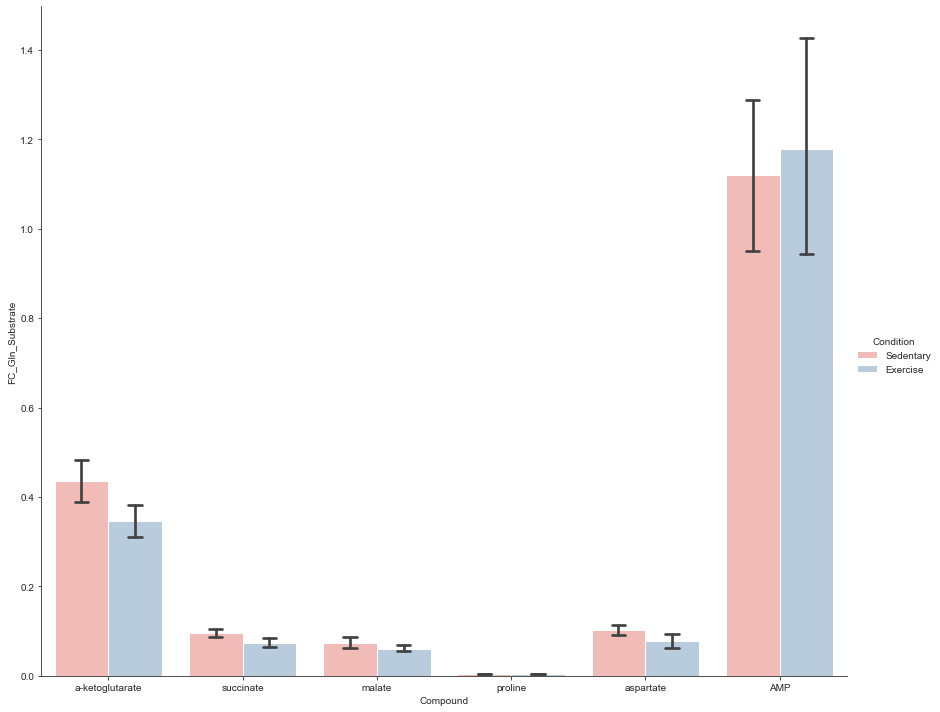

In [15]:
#This nested for loop prints out every APE for every sample and every metabolite

#arange starts at 2 because the first two columns are strings, and I then have to add that same number (2) in order to complete the list
Sample = []
Compound = []
APE = []

for metabolite in tissue13C_metabolites:
    for sample in np.arange(2,(len(quad_13C_samples)+2)):

        #I have to do sample minus 1, because I want to start from the third column in my dataframes (which is the first mouse)

        x, y, z = (sample-1, metabolite, fc.FractionalAPE(dict_of_quad13C_metabolites[metabolite].iloc[:, sample]))
        Sample.append(x)
        Compound.append(y)
        APE.append(z)

quad_APEs = pd.DataFrame({'Sample': Sample, 'Compound': Compound, 'APE': APE})

#Add a column to the dataframe that puts plasma glutamine APE
quad_APEs['Plasma_Glutamine_APE'] = plasmaglutamine_APE * len(quad_APEs['Compound'].unique())
#add a column that specifies the mouse's Condition
quad_APEs['Condition'] = ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary'] * len(quad_APEs['Compound'].unique())
#add a column that plots the FC_Glu-->Compound as APE / Plasma_Glutamine_APE
quad_APEs['FC_Gln_Substrate'] = quad_APEs['APE'] / quad_APEs['Plasma_Glutamine_APE']
#add a column that specifies the tissue for the combined dataframe later
quad_APEs['Tissue'] = 'quad'

sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=quad_APEs, saturation=0.75, palette = 'Pastel1', order=['a-ketoglutarate', 'succinate', 'malate', 'proline','aspartate', 'AMP'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=1.2)

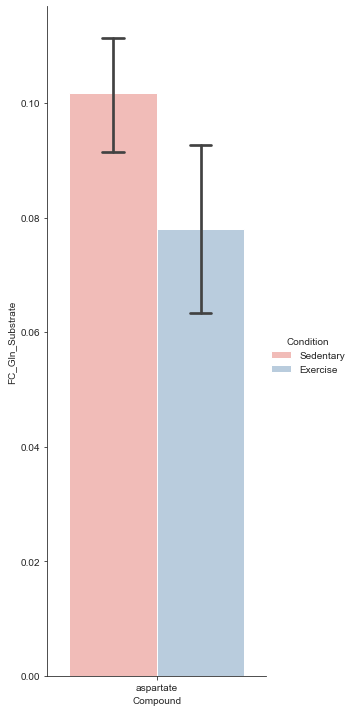

In [34]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=quad_APEs, saturation=0.75, palette = 'Pastel1', order=['aspartate'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=0.4)
plt.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/FC_Gln_Asp_Quad.svg', dpi=300, bbox_inches='tight')

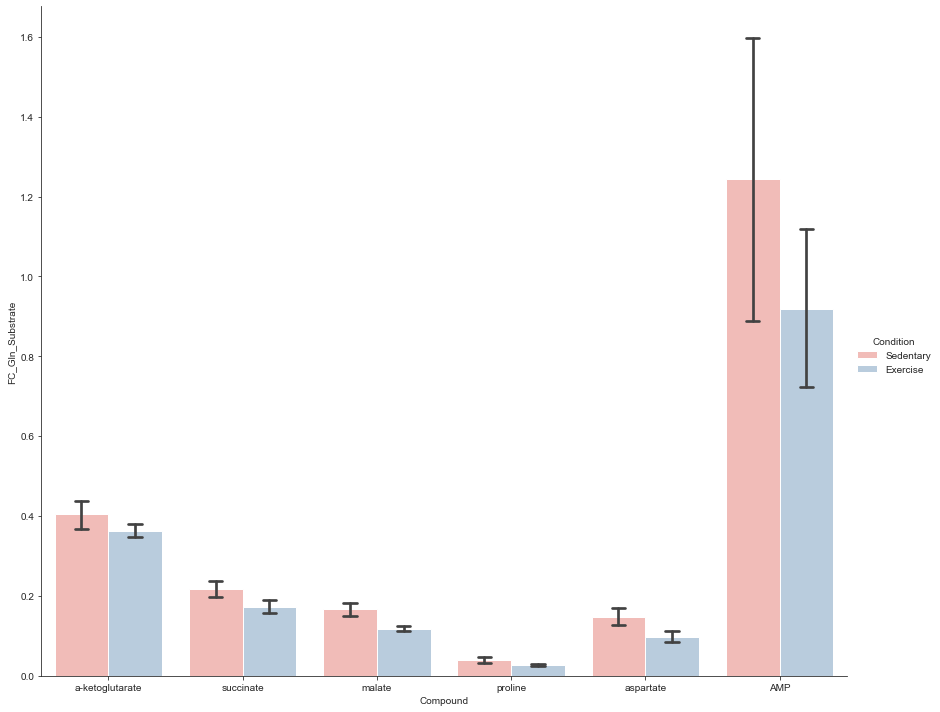

In [16]:
#This nested for loop prints out every APE for every sample and every metabolite

#arange starts at 2 because the first two columns are strings, and I then have to add that same number (2) in order to complete the list
Sample = []
Compound = []
APE = []

for metabolite in tissue13C_metabolites:
    for sample in np.arange(2,(len(tumor_13C_samples)+2)):

        #I have to do sample minus 1, because I want to start from the third column in my dataframes (which is the first mouse)

        x, y, z = (sample-1, metabolite, fc.FractionalAPE(dict_of_tumor13C_metabolites[metabolite].iloc[:, sample]))
        Sample.append(x)
        Compound.append(y)
        APE.append(z)

tumor_APEs = pd.DataFrame({'Sample': Sample, 'Compound': Compound, 'APE': APE})

#Add a column to the dataframe that puts plasma glutamine APE
tumor_APEs['Plasma_Glutamine_APE'] = plasmaglutamine_APE * len(tumor_APEs['Compound'].unique())
#add a column that specifies the mouse's Condition
tumor_APEs['Condition'] = ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary'] * len(tumor_APEs['Compound'].unique())
#add a column that plots the FC_Glu-->Compound as APE / Plasma_Glutamine_APE
tumor_APEs['FC_Gln_Substrate'] = tumor_APEs['APE'] / tumor_APEs['Plasma_Glutamine_APE']
#add a column that specifies the tissue for the combined dataframe later
tumor_APEs['Tissue'] = 'tumor'

sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=tumor_APEs, saturation=0.75, palette = 'Pastel1', order=['a-ketoglutarate', 'succinate', 'malate', 'proline','aspartate', 'AMP'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=1.2)

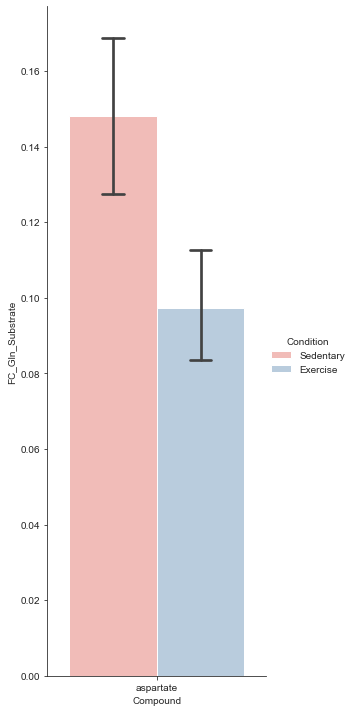

In [36]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.catplot(x="Compound", y="FC_Gln_Substrate", hue="Condition",
                data=tumor_APEs, saturation=0.75, palette = 'Pastel1', order=['aspartate'], 
                hue_order=['Sedentary', 'Exercise'],
                sharey=False, kind="bar", height=10, ci=68, capsize=.1, aspect=0.4)

plt.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/FC_Gln_Asp_Tumor.svg', dpi=300, bbox_inches='tight')

In [37]:
summary_APE_df = pd.concat([heart_APEs, kidney_APEs, liver_APEs, quad_APEs, tumor_APEs])

In [38]:
summary_APE_df.to_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/data/metabolomics/FractionalContributions.csv')

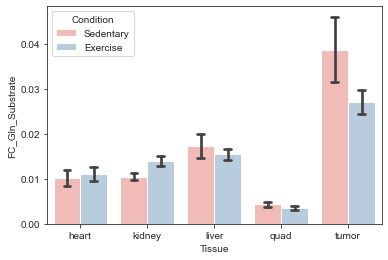

In [39]:
sns.barplot(data=summary_APE_df[summary_APE_df['Compound'] == 'proline'], x='Tissue', y='FC_Gln_Substrate', palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'], hue='Condition', ci=68, capsize=.1)
plt.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/FC_Gln_to_Proline.svg', bbox_inches="tight", dpi=300)

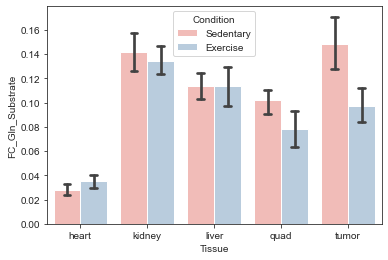

In [40]:
sns.barplot(data=summary_APE_df[summary_APE_df['Compound'] == 'aspartate'], x='Tissue', y='FC_Gln_Substrate', palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'], hue='Condition', ci=68, capsize=.1)
plt.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/FC_Gln_to_aspartate.svg', bbox_inches="tight", dpi=300)

In [41]:
summary_APE_df[summary_APE_df['Compound'] == 'malate'].to_csv('../data/gln_to_malate.csv')

In [42]:
tca = ['a-ketoglutarate', 'malate', 'succinate']

tca_APE = summary_APE_df[summary_APE_df['Compound'].isin(tca)]
#ca_APE.to_csv('../data/flux/sepsis_fluxomics/targeted_tissue_tracing/tca_APE_forstats.csv')

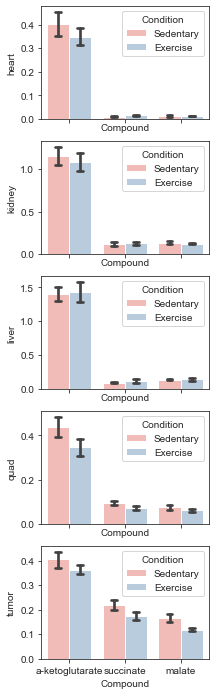

In [43]:
# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(3, 12), sharex=True)

sns.barplot(data=tca_APE[tca_APE['Tissue'] == 'heart'], x='Compound', y='FC_Gln_Substrate', hue='Condition', order=['a-ketoglutarate', 'succinate', 'malate'], palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'],ax=ax1, ci=68, capsize=.1)
ax1.set_ylabel("heart")

sns.barplot(data=tca_APE[tca_APE['Tissue'] == 'kidney'], x='Compound', y='FC_Gln_Substrate', hue='Condition', order=['a-ketoglutarate', 'succinate', 'malate'], palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'],ax=ax2, ci=68, capsize=.1)
ax2.set_ylabel("kidney")

sns.barplot(data=tca_APE[tca_APE['Tissue'] == 'liver'], x='Compound', y='FC_Gln_Substrate', hue='Condition', order=['a-ketoglutarate', 'succinate', 'malate'], palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'],ax=ax3, ci=68, capsize=.1)
ax3.set_ylabel("liver")

sns.barplot(data=tca_APE[tca_APE['Tissue'] == 'quad'], x='Compound', y='FC_Gln_Substrate', hue='Condition', order=['a-ketoglutarate', 'succinate', 'malate'], palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'],ax=ax4, ci=68, capsize=.1)
ax4.set_ylabel("quad")

sns.barplot(data=tca_APE[tca_APE['Tissue'] == 'tumor'], x='Compound', y='FC_Gln_Substrate', hue='Condition', order=['a-ketoglutarate', 'succinate', 'malate'], palette = 'Pastel1', hue_order=['Sedentary', 'Exercise'],ax=ax5, ci=68, capsize=.1)
ax5.set_ylabel("tumor")

plt.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/FC_Gln_to_TCA.svg', bbox_inches="tight", dpi=300)